# Bài tập trên lớp về Spam Filtering
Trong bài tập này, chúng ta sẽ sử dụng các công cụ mạnh mẽ có sẵn như pandas/sklearn để thực hiện công việc phân biệt giữa mail spam và mail thường qua thông tin của chính email đó.

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
cd drive/MyDrive/NLP_VINAI/Lesson7/Class/

[Errno 2] No such file or directory: 'drive/MyDrive/NLP_VINAI/Lesson7/Class/'
/content/drive/MyDrive/NLP_VINAI/Lesson7/Class


## Download dữ liệu
Dữ liệu được tải về bằng gdown vào cùng folder với file hiện tại. Sau khi tải, chúng ta unzip dữ liệu nhận được.

In [5]:
!gdown https://drive.google.com/uc?id=1bTJKchSInd3IgLs41b1_-Gd-T36a_pal -O spam_data.zip

Downloading...
From: https://drive.google.com/uc?id=1bTJKchSInd3IgLs41b1_-Gd-T36a_pal
To: /content/drive/My Drive/NLP_VINAI/Lesson7/Class/spam_data.zip
100% 1.95M/1.95M [00:00<00:00, 160MB/s]


In [10]:
!unzip spam_data.zip

Archive:  spam_data.zip
  inflating: spam_ham_dataset.csv    


## Sử dụng pandas để lưu trữ
Pandas là thư viện thường được sử dụng để cất giữ dữ liệu được sử dụng trong quá trình thực hiện các phương pháp học máy, với các chức năng phù hợp với dữ liệu lớn và hiệu năng cao. Chúng ta đọc dữ liệu của file đã được unzip vào một `DataFrame`.

In [11]:
import pandas as pd
data_loc = "spam_ham_dataset.csv"

spam_data = pd.read_csv(data_loc, header=0)
spam_data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [12]:
print("\n\n\n".join(spam_data[spam_data["label"] == "spam"][:5]["text"].values))

Subject: photoshop , windows , office . cheap . main trending
abasements darer prudently fortuitous undergone
lighthearted charm orinoco taster
railroad affluent pornographic cuvier
irvin parkhouse blameworthy chlorophyll
robed diagrammatic fogarty clears bayda
inconveniencing managing represented smartness hashish
academies shareholders unload badness
danielson pure caffein
spaniard chargeable levin



Subject: looking for medication ? we ` re the best source .
it is difficult to make our material condition better by the best law , but it is easy enough to ruin it by bad laws .
excuse me . . . : ) you just found the
best and simpliest site for
medication on the net . no perscription , easy
delivery .
private , secure , and easy .
better see rightly on a pound a week than squint on a million .
we ` ve got
anything that you will ever want .
erection treatment pills , anti - depressant pills , weight loss , and
more ! http : / / splicings . bombahakcx . com / 3 /
knowledge and human powe

## Data preprocessing
Như chúng ta có thể thấy, dữ liệu hiện tại đang chứa ký tự xuống dòng \r\n của Window và có thể dẫn đến lẫn lộn. Để đơn giản hóa, chúng ta thay nó bằng dấu cách. Các bạn có thể ứng dụng phương án của pandas để thực hiện thêm (v.d xóa chữ Subject: từ đầu, nhặt ra dòng đầu tiên, etc.)

In [13]:
spam_data["text"] = spam_data["text"].apply(lambda x: x.replace("\r\n", " "))

Lower text

In [29]:
spam_data['text'] = spam_data['text'].apply(lambda x:x.lower())

## Building Model
Đầu tiên, chúng ta thực hiện Vector hóa dữ liệu đầu vào qua `CountVectorizer` với mục tiêu là vector hóa dữ liệu từ. `CountVectorizer` có nhiệm vụ tạo một vocab các từ xuất hiện trong dữ liệu, và tạo một vector tương ứng cho mỗi sample là lần xuất hiện của các từ trong sample đó.

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(min_df=3, max_df=0.95)
count_data = count.fit_transform(spam_data["text"])
count_data.shape

(5171, 14238)

Tiếp đó, chúng ta áp dụng thuật toán TF-IDF lên vector đã tìm được. Dữ liệu được trả ra vẫn sẽ là một ma trận sparse, nhưng đã được adapt cho độ hiếm của mỗi từ.

In [31]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
trans_data = transformer.fit_transform(count_data)
trans_data.shape

(5171, 14238)

Chúng ta có thể tạo dữ liệu dạng n-gram qua argument `ngram_range` cho `CountVectorizer`, điều này cho phép chương trình lưu xuống các cụm n-từ thường thấy trong dữ liệu.
Ngoài ra, `CountVectorizer` và `TfidfTransformer` có một wrapper tổng hợp cả 2 quá trình vào 1 và nhận chung các argument của chúng: `TfidfVectorizer`

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3), min_df=3, max_df=0.95)
matrix_data = vectorizer.fit_transform(spam_data["text"])
print(matrix_data.shape)

(5171, 63816)


Sau khi hoàn thành các bước vector hóa, chúng ta tiếp tục phân hóa dữ liệu thành tập train và tập test để đánh giá chất lượng mô hình.

In [33]:
from sklearn.model_selection import train_test_split
X_data = matrix_data; y_data = spam_data["label_num"].values
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=0)

Sau khi chúng ta đã có dữ liệu đã vector hóa, chúng ta sử dụng một mô hình Bayes để tính kết quả. VD như hiện tại, sử dụng GaussianNB. Chúng ta có thể sử dụng nhiều mô hình học máy khác vào đây (e.g LogisticRegression, SVM).

*Lưu ý: todense() được sử dụng để chuyển một ma trận sparse sang dense, có thể dẫn đến MemoryError với các dữ liệu lớn. Cân nhắc sử dụng các mô hình chấp nhận train qua ma trận sparse hoặc implement phương án của bản thân ở đây.*

In [34]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train.todense(), y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


GaussianNB()

In [35]:
y_pred = model.predict(X_test.todense())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


## Metrics and Visualization
Để đánh giá chất lượng mô hình, chúng ta có thể tính số điểm F1 hoặc accuracy. Trong trường hợp này chúng ta dùng F1 do độ phủ của class trong dữ liệu không giống nhau (25% là spam). Chúng ta cũng có thể in đường cong ROC-AUC để biểu thị các vị trí cutoff khác nhau cho mô hình

In [36]:
from sklearn.metrics import f1_score, accuracy_score
print("F1 Score: {:.4f}".format(f1_score(y_pred, y_test)))

F1 Score: 0.9632


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


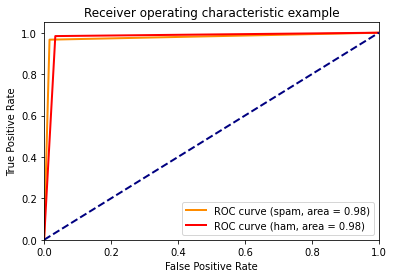

In [37]:
from sklearn.metrics import roc_curve, auc
%matplotlib inline
y_pred_proba = model.predict_proba(X_test.todense())
fpr_spam, tpr_spam, thresholds = roc_curve(y_test, y_pred_proba[:, 1], pos_label=1)
roc_auc_spam = auc(fpr_spam, tpr_spam)
fpr_ham, tpr_ham, thresholds = roc_curve(y_test, y_pred_proba[:, 0], pos_label=0)
roc_auc_ham = auc(fpr_spam, tpr_ham)

import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(fpr_spam, tpr_spam, color='darkorange',
         lw=lw, label='ROC curve (spam, area = %0.2f)' % roc_auc_spam)
plt.plot(fpr_ham, tpr_ham, color='red',
         lw=lw, label='ROC curve (ham, area = %0.2f)' % roc_auc_ham)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

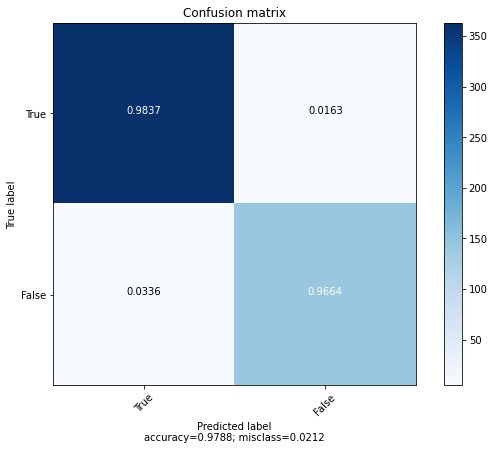

In [38]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ["True", "False"])
plt.show()

## Alternative: Co-occurence and TruncatedSVD
Trong ngôn ngữ, chúng ta thường thấy các từ có liên quan về ý nghĩa (vd. bác_sĩ và bệnh_nhân) thường sẽ xuất hiện trong cùng ngữ cảnh. Từ suy nghĩ trên, chúng ta có thể xây dựng một ma trận đồng xuất hiện (co-occurence) giữa các từ xuất hiện trong câu; điều này cho phép chúng ta biểu diễn các từ trong ngôn ngữ qua một không gian vector chung thay vì giá trị đếm.

Ma trận co-occurence với window là toàn bộ câu có thể được xây dựng bằng dữ liệu CountVectorizer đã có hoặc trực tiếp làm bằng tay.

In [39]:
# 
coocr = count_data.T * count_data

In [40]:
index_free = count.vocabulary_["free"]
index_call = count.vocabulary_["call"]
print("Cooccurence between word `free` and `call`: ", coocr[index_free, index_call])

Cooccurence between word `free` and `call`:  188


Thư viện `sklearn` đã có sẵn implementation của SVD được gọi là `TruncatedSVD`, cho phép biến đổi một lượng feature M xuống lượng feature N dựa trên việc sử dụng ma trận đồng xuất hiện như trên. Phương pháp này trong miền NLP còn có tên khác là Latent Semantic Analysis (LSA). Sử dụng một model để thử nghiệm kết quả khi sử dụng `TruncatedSVD` để hạ chiều của dữ liệu xuống còn 512.

In [41]:
from sklearn.model_selection import train_test_split
X_cdata = count_data; # y_data = spam_data["label_num"].values
X_ctrain, X_ctest, y_ctrain, y_ctest = train_test_split(X_cdata, y_data, test_size=0.1, random_state=10)

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(512, random_state=1)
X_ctrain = svd.fit_transform(X_ctrain)
X_ctest = svd.transform(X_ctest)

from sklearn.linear_model import LogisticRegression
cmodel = LogisticRegression(solver="lbfgs", max_iter=1000)
cmodel.fit(X_ctrain, y_ctrain)
y_cpred = cmodel.predict(X_ctest)

print("F1 Score for TruncatedSVD model: {:.4f}".format(f1_score(y_cpred, y_ctest)))

F1 Score for TruncatedSVD model: 0.9600


## Alternative: HashingVectorizer
Với các bộ dữ liệu lớn dẫn đến vocab cao, việc sử dụng CountVectorizer thông thường để lưu trữ dữ liệu vector hóa trở nên tốn tài nguyên; Một phương pháp chúng ta có thể cân nhắc là sử dụng HashingVectorizer. Thay vì CountVectorizer biến mỗi từ/ngram thành 1 id tương ứng, nhiều từ của HashingVectorizer sẽ có thể cho nhiều từ vào 1 id xác định bằng mảng băm.

Lựa chọn giữa 2 phương pháp là tradeoff giữa tài nguyên lưu trữ như RAM và chất lượng mô hình. Thay đổi giá trị n_features và cân nhắc tradeoff ở bao nhiêu là phù hợp để mô hình không bị kém đi quá nhiều.

In [42]:
from sklearn.feature_extraction.text import TfidfTransformer, HashingVectorizer

hashed_data = HashingVectorizer(n_features=5000, ngram_range=(1, 3), stop_words='english').fit_transform(spam_data["text"])
hashed_matrix_data = TfidfTransformer().fit_transform(hashed_data)

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score

X_htrain, X_htest, y_htrain, y_htest = train_test_split(hashed_matrix_data, y_data, test_size=0.1, random_state=0)
model = GaussianNB()
model.fit(X_htrain.todense(), y_htrain)
y_hpred = model.predict(X_htest.todense())
print("F1 Score for HashedVectorizer: {:.4f}".format(f1_score(y_hpred, y_htest)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


F1 Score for HashedVectorizer: 0.8580


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
